###Note: this tutorial needs updating and has not been recently tested for basic functionality: use at own risk

In [1]:
import pygsti
import os
import sys
#The following two lines should be changed to reflect your own paths to GST/src and GSTData/data/Ion_Trap_SNL/2015_03_30/GST_BB1_XX_512_condensed.txt 
sys.path.append('/Users/kmrudin/GST/src/')
dataFile = '/Users/kmrudin/GSTData/data/Ion_Trap_SNL/2015_03_30/GST_BB1_XX_512_condensed.txt'
import Bootstrap

In [2]:
%pylab inline
#Only include this line if you've upgraded to the latest version of IPython (Jupyter)

Populating the interactive namespace from numpy and matplotlib


In [3]:
import time

In [4]:
#Build the target gateset, here [I, X_pi/2, Y_pi/2]
gs_target = GST.build_gateset([2],[('Q0',)], ['Gi','Gx','Gy'], 
                             [ "I(Q0)","X(-pi/2,Q0)", "Y(-pi/2,Q0)"],
                             rhoExpressions=["0"], EExpressions=["1"], 
                             spamLabelDict={'plus': (0,0), 'minus': (0,-1) } )

In [5]:
fiducials = [ (), ('Gx',), ('Gy',), ('Gx','Gx'), ('Gx','Gx','Gx'), ('Gy','Gy','Gy') ] # fiducials for 1Q MUB

germs_all = [('Gx',), ('Gy',), ('Gi',), ('Gx', 'Gy'),
         ('Gx', 'Gy', 'Gi'), ('Gx', 'Gi', 'Gy'), ('Gx', 'Gi', 'Gi'), ('Gy', 'Gi', 'Gi'),
         ('Gx', 'Gx', 'Gi', 'Gy'), ('Gx', 'Gy', 'Gy', 'Gi'),
         ('Gx', 'Gx', 'Gy', 'Gx', 'Gy', 'Gy')]

maxLengths512 = [0,1,2,4,8,16,32,64,128,256,512]

specs = GST.get_spam_specs(fiducials)

In [6]:
def make_lists_trunc(gateLabels, fiducialList, germList, maxLengthList, truncType):
    
    truncPowFunc = GST.GateStringTools.repeat_count_with_max_length
    if truncType == "A":  #truncate germ powers to exactly maxLength
        truncFunc = GST.GateStringTools.repeat_and_truncate
        truncRemFunc = GST.GateStringTools.repeat_remainder_for_truncation
    elif truncType == "B": #truncate to integer germ power
        truncFunc = GST.GateStringTools.repeat_with_max_length
        truncRemFunc = GST.GateStringTools.repeat_empty #just returns empty tuple
    elif truncType == "old": #raise germ to maxLength (treat maxLength as exponent - OLD)
        truncFunc = GST.GateStringTools.repeat
        truncRemFunc = GST.GateStringTools.repeat_empty
    
    lgstStrings = GST.list_lgst_gatestrings(GST.get_spam_specs(fiducialList), gateLabels)
    singleGates = [(g,) for g in gateLabels]

    lsgst_list = [ () ]; elgst_list = [ () ]
    if maxLengthList[0] == 0:
        lsgst_listOfLists = [ lgstStrings ]
        elgst_listOfLists = [ singleGates ]
        maxLengthList = maxLengthList[1:]
    else:
        lsgst_listOfLists = [ ]
        elgst_listOfLists = [ ]
        
    for maxLen in maxLengthList:
        lsgst_list += GST.create_gatestring_list("f0+R(germ,N)+f1", f0=fiducialList,
                                           f1=fiducialList, germ=germList, N=maxLen,
                                           R=truncFunc, order=('germ','f0','f1'))
        lsgst_listOfLists.append( GST.ListTools.remove_duplicates(lgstStrings + lsgst_list) )
        
        elgst_list += GST.create_gatestring_list("R(germ,N)", germ=germList, N=maxLen, R=truncFunc)
        elgst_listOfLists.append( GST.ListTools.remove_duplicates(singleGates + elgst_list) )
    
    #Create gate string labels (for a readable dataset file)
    strList = [ "{}" ] #constructed in parallel with lsgst_list above
    for maxLen in maxLengthList:
        strList += GST.create_gatestring_list("S(f0)+'('+S(germ)+')^'+str(M(germ,N))+S(R(germ,N)+f1)", 
                                            f0=fiducialList, f1=fiducialList, germ=germList,
                                            N=maxLen, M=truncPowFunc, R=truncRemFunc, 
                                            S=GST.GateStringTools.gate_seq_to_str,order=('germ','f0','f1'))
    strList = list(map(GST.GateStringTools.simplify_str, strList))
    labelsAndStrings = list(zip(strList,lsgst_list))
    #print "%d initial strings" % len(labelsAndStrings)
    
    #Remove duplicates here
    GST.ListTools.remove_duplicates_in_place( labelsAndStrings, indexToTest=1 ) #only test gate string tuple for duplicates, not label
    #print "%d strings after removing duplicates" % len(labelsAndStrings)

    # ensure LGST strings are present in dataset
    for s in lgstStrings:
        if s not in lsgst_list: #note: ok that lsgst_list may have duplicates
            labelsAndStrings.append( (GST.GateStringTools.gate_seq_to_str(s), s) )
    
    print ""
    print "%d eLGST sets w/lengths" % len(elgst_listOfLists),map(len,elgst_listOfLists)
    print "%d LSGST sets w/lengths" % len(lsgst_listOfLists),map(len,lsgst_listOfLists)
    print "%d labelled strings for dataset creation" % len(labelsAndStrings)
    return elgst_listOfLists, lsgst_listOfLists, labelsAndStrings

In [7]:
DS_GST_BB1_XX_512_condensed = GST.load_dataset(dataFile)

Loading /Users/kmrudin/GSTData/data/Ion_Trap_SNL/2015_03_30/GST_BB1_XX_512_condensed.txt: 100%


In [8]:
elgstLists512, lsgstLists512, datasetLabelsAndList512 = \
    make_lists_trunc(['Gi','Gx','Gy'], fiducials, germs_all, maxLengths512, "B")


11 eLGST sets w/lengths [3, 4, 8, 18, 29, 40, 51, 62, 73, 84, 95]
11 LSGST sets w/lengths [92, 92, 168, 441, 817, 1201, 1585, 1969, 2353, 2737, 3121]
3121 labelled strings for dataset creation


LGST: Singular values of I_tilde (truncating to first 4 of 6) = 
[  3.02941030e+00   1.00270893e+00   9.88945703e-01   9.71010880e-01
   4.00352504e-02   1.18193822e-04]

--- LGST ---

--- Iterative LSGST: Beginning iter 1 of 11 : 92 gate strings ---
--- Least Squares GST ---
  Sum of Chi^2 = 66.3489 (92 data params - 56 model params = expected mean of 36)

--- Iterative LSGST: Beginning iter 2 of 11 : 92 gate strings ---
--- Least Squares GST ---
  Sum of Chi^2 = 66.3489 (92 data params - 56 model params = expected mean of 36)

--- Iterative LSGST: Beginning iter 3 of 11 : 168 gate strings ---
--- Least Squares GST ---
  Sum of Chi^2 = 149.146 (168 data params - 56 model params = expected mean of 112)

--- Iterative LSGST: Beginning iter 4 of 11 : 441 gate strings ---
--- Least Squares GST ---
  Sum of Chi^2 = 430.313 (441 data params - 56 model params = expected mean of 385)

--- Iterative LSGST: Beginning iter 5 of 11 : 817 gate strings ---
--- Least Squares GST ---
  Sum of Chi^2 =

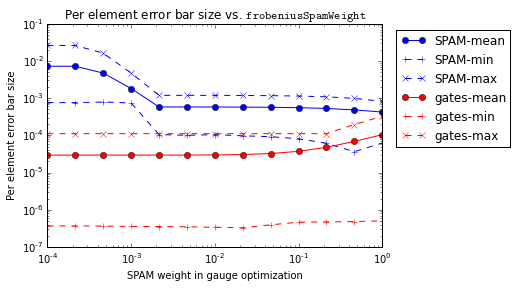

In [9]:
#Here we are doing parametric bootstrapping, as indicated by the 'parametric' argument passed in.
#As returnData==False, the output is the tuple (Gateset mean, Gateset stdev),
# as opposed to (Gateset mean, Gateset stdev, list of sim. gate sets, dictionary of all simulated data).
#It is this Gateset stdev quantity which is the collection of error bars.
#Due to print setting issues, the outputs that are printed here will not reflect the true accuracy of the estimates made.

NumResamples=10#The number of simulated datasets made for bootstrapping purposes.  For good statistics, should probably be greater than 10.
start = time.time()
ErrorBarData_Param_GST_BB1_XX_512_condensed = Bootstrap.makeBootstrappedErrorBars(DS_GST_BB1_XX_512_condensed,
                                                                            lsgstLists512, gs_target, specs, 'parametric',
                                                                            NumResamples, ddof=1, returnData=False)
end = time.time()
print end - start

In [10]:
#Summary of the error bars
print "Parametric bootstrapped error bars, with",NumResamples,"resamples\n"
print "Error in rho vec:" 
print ErrorBarData_Param_GST_BB1_XX_512_condensed[1].rhoVecs[0]
print
print "Error in E vec:"
print ErrorBarData_Param_GST_BB1_XX_512_condensed[1].rhoVecs[0]
print
print "Error in Gi:"
print ErrorBarData_Param_GST_BB1_XX_512_condensed[1]['Gi']
print
print "Error in Gx:"
print ErrorBarData_Param_GST_BB1_XX_512_condensed[1]['Gx']
print
print "Error in Gy:"
print ErrorBarData_Param_GST_BB1_XX_512_condensed[1]['Gy']

Parametric bootstrapped error bars, with 10 resamples

Error in rho vec:
[[ 0.00010491]
 [ 0.00075342]
 [ 0.00118994]
 [ 0.00024782]]

Error in E vec:
[[ 0.00010491]
 [ 0.00075342]
 [ 0.00118994]
 [ 0.00024782]]

Error in Gi:
[[  4.57577793e-07   9.71479054e-06   9.09676172e-06   2.34922584e-05]
 [  1.04321825e-05   9.32505159e-06   8.67726274e-05   7.00323223e-05]
 [  2.92788743e-05   9.33180516e-05   5.46524211e-05   5.50483315e-05]
 [  3.36687331e-05   9.02027472e-05   1.10839062e-04   7.66040429e-05]]

Error in Gx:
[[  3.53465094e-07   1.19110175e-05   6.24394387e-06   6.40696305e-06]
 [  1.00876870e-05   1.25056302e-05   3.83825183e-05   2.94981842e-05]
 [  6.12273119e-06   3.46086293e-05   4.59635644e-05   1.29121905e-05]
 [  6.57655815e-06   2.60660051e-05   1.52260306e-05   5.75325717e-05]]

Error in Gy:
[[  3.87136623e-07   6.06396933e-06   9.76979564e-06   5.88815729e-06]
 [  6.43204052e-06   4.62893118e-05   5.15335266e-05   1.16953949e-05]
 [  1.20798963e-05   4.63010446e-0

******************************
Computing simulation 0
******************************
LGST: Singular values of I_tilde (truncating to first 4 of 6) = 
[ 3.02780967  1.03101089  0.9874279   0.94217977  0.03444397  0.00427656]

--- LGST ---

--- Iterative LSGST: Beginning iter 1 of 11 : 92 gate strings ---
--- Least Squares GST ---
  Sum of Chi^2 = 111.377 (92 data params - 56 model params = expected mean of 36)

--- Iterative LSGST: Beginning iter 2 of 11 : 92 gate strings ---
--- Least Squares GST ---
  Sum of Chi^2 = 111.377 (92 data params - 56 model params = expected mean of 36)

--- Iterative LSGST: Beginning iter 3 of 11 : 168 gate strings ---
--- Least Squares GST ---
  Sum of Chi^2 = 251.557 (168 data params - 56 model params = expected mean of 112)

--- Iterative LSGST: Beginning iter 4 of 11 : 441 gate strings ---
--- Least Squares GST ---
  Sum of Chi^2 = 740.063 (441 data params - 56 model params = expected mean of 385)

--- Iterative LSGST: Beginning iter 5 of 11 : 817 gate 

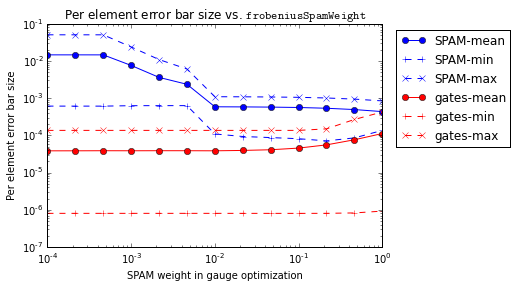

In [11]:
#Here we are doing nonparametric bootstrapping, as indicated by the 'nonparametric' argument passed in.
#As returnData==False, the output is the tuple (Gateset mean, Gateset stdev),
# as opposed to (Gateset mean, Gateset stdev, list of sim. gate sets, dictionary of all simulated data).
#It is this Gateset stdev quantity which is the collection of error bars.
#Due to print setting issues, the outputs that are printed here will not reflect the true accuracy of the estimates made.
#Note that ddof==1, meaning that we are computing a standard deviation of the sample, not of the population.

NumResamples=10#The number of simulated datasets made for bootstrapping purposes.  For good statistics, should probably be greater than 10.
start = time.time()
ErrorBarData_NonParam_GST_BB1_XX_512_condensed = Bootstrap.makeBootstrappedErrorBars(DS_GST_BB1_XX_512_condensed,
                                                                            lsgstLists512, gs_target, specs, 'nonparametric',
                                                                            NumResamples, ddof=1, returnData=False)
end = time.time()
print end - start

In [12]:
#Summary of the error bars
print "Nonparametric bootstrapped error bars, with",NumResamples,"resamples\n"
print "Error in rho vec:" 
print ErrorBarData_NonParam_GST_BB1_XX_512_condensed[1].rhoVecs[0]
print
print "Error in E vec:"
print ErrorBarData_NonParam_GST_BB1_XX_512_condensed[1].rhoVecs[0]
print
print "Error in Gi:"
print ErrorBarData_NonParam_GST_BB1_XX_512_condensed[1]['Gi']
print
print "Error in Gx:"
print ErrorBarData_NonParam_GST_BB1_XX_512_condensed[1]['Gx']
print
print "Error in Gy:"
print ErrorBarData_NonParam_GST_BB1_XX_512_condensed[1]['Gy']

Nonparametric bootstrapped error bars, with 10 resamples

Error in rho vec:
[[ 0.00010912]
 [ 0.00063508]
 [ 0.00105847]
 [ 0.00028727]]

Error in E vec:
[[ 0.00010912]
 [ 0.00063508]
 [ 0.00105847]
 [ 0.00028727]]

Error in Gi:
[[  1.55283842e-06   7.68862590e-06   1.34004673e-05   2.03822435e-05]
 [  1.09096531e-05   1.31065006e-05   1.00883113e-04   7.60893300e-05]
 [  2.97276287e-05   5.18250252e-05   9.35659671e-05   1.12740861e-04]
 [  3.35958300e-05   8.82223688e-05   1.35927545e-04   1.19567393e-04]]

Error in Gx:
[[  9.96609970e-07   8.91843813e-06   7.02040072e-06   1.06009068e-05]
 [  1.16295035e-05   1.50915455e-05   5.10371006e-05   5.87735540e-05]
 [  1.20849767e-05   7.01213898e-05   7.89584952e-05   1.26772275e-05]
 [  1.02031120e-05   5.72588229e-05   1.32105630e-05   5.39114927e-05]]

Error in Gy:
[[  8.00152208e-07   1.11605088e-05   8.75448842e-06   9.30988924e-06]
 [  1.20329453e-05   6.05573540e-05   6.34566738e-05   8.91180010e-06]
 [  1.27115959e-05   6.17696610

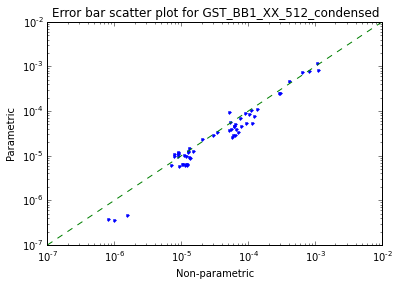

In [14]:
loglog(ErrorBarData_NonParam_GST_BB1_XX_512_condensed[1].to_vector(),ErrorBarData_Param_GST_BB1_XX_512_condensed[1].to_vector(),'.')
loglog(np.logspace(-7,-2,10),np.logspace(-7,-2,10),'--')
xlabel('Non-parametric')
ylabel('Parametric')
title('Error bar scatter plot for GST_BB1_XX_512_condensed')